In [1]:
import pandas as pd
df = pd.read_csv('Data/Stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
print("Raw Counts")
print(df['stroke'].value_counts())
print()
print('Percentages')
print(df['stroke'].value_counts(normalize=True))

Raw Counts
0    4861
1     249
Name: stroke, dtype: int64

Percentages
0    0.951272
1    0.048728
Name: stroke, dtype: float64


<AxesSubplot:xlabel='stroke', ylabel='count'>

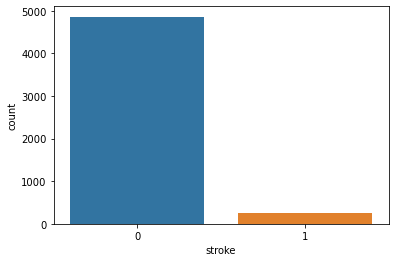

In [6]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.countplot(df['stroke'])

In [7]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
df['bmi'] = df['bmi'].fillna(df.bmi.mean())
df['bmi'] = df['bmi'].round(decimals=1)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
one_hot_df = pd.get_dummies(df)
one_hot_df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,51676,61.0,0,0,202.21,28.9,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.5,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.4,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,1,0,174.12,24.0,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0


In [10]:
y = one_hot_df['stroke']
X = one_hot_df.drop(columns=['id', 'stroke'], axis=1)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    3645
1     187
Name: stroke, dtype: int64 

 0    1216
1      62
Name: stroke, dtype: int64


In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

neg_log_loss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
logreg_baseline_model = LogisticRegression(random_state=42)
kfold_scores = np.ndarray(5)
kfold = StratifiedKFold()
for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    temp_model = clone(logreg_baseline_model)
    temp_model.fit(X_t, y_t)
    neg_log_loss_score = neg_log_loss(temp_model, X_val, y_val)
    kfold_scores[fold] = neg_log_loss_score
-(kfold_scores.mean())

0.1601982418748703

In [13]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def custom_cross_val_score(estimator, X, y):
    kfold_train_scores = np.ndarray(5)
    kfold_val_scores = np.ndarray(5)
    kfold = StratifiedKFold(n_splits=5)
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        X_t, X_val = X.iloc[train_index], X.iloc[val_index]
        y_t, y_val = y.iloc[train_index], y.iloc[val_index]
        scaler = StandardScaler()
        X_t_scaled = scaler.fit_transform(X_t)
        X_val_scaled = scaler.transform(X_val)
        sm = SMOTE(random_state=42, sampling_strategy=0.20)
        X_t_oversampled, y_t_oversampled = sm.fit_resample(X_t_scaled, y_t)
        temp_model = clone(estimator)
        temp_model.fit(X_t_oversampled, y_t_oversampled)
        neg_log_loss_score_train = neg_log_loss(temp_model, X_t_oversampled, y_t_oversampled)
        neg_log_loss_score_val = neg_log_loss(temp_model, X_val_scaled, y_val)
        kfold_train_scores[fold] = neg_log_loss_score_train
        kfold_val_scores[fold] = neg_log_loss_score_val
    return kfold_train_scores, kfold_val_scores

In [14]:
logreg_first_model = LogisticRegression(random_state=42, class_weight={1:0.20})
preprocessed_train_scores, preprocessed_neg_log_loss_cv = custom_cross_val_score(
    logreg_first_model,
    X_train,
    y_train)
-(preprocessed_neg_log_loss_cv.mean())

0.16307188766445013

In [15]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def print_metrics(labels, preds):
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))

In [16]:
logreg_baseline_model.fit(X_train, y_train)
preds_logreg = logreg_baseline_model.predict(X_test)
print("Logistic Regression Baseline Model:")
print_metrics(y_test, preds_logreg)

Logistic Regression Baseline Model:
Accuracy Score: 0.9522691705790297
Precision Score: 1.0
Recall Score: 0.016129032258064516


In [17]:
logreg_baseline_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [18]:
logreg_second_model = LogisticRegression(
    random_state=42,
    solver='saga', 
    penalty='elasticnet',
    l1_ratio=0.5)
second_model_train_scores, second_model_val_scores = custom_cross_val_score(
    logreg_second_model,
    X_train, 
    y_train)
-(second_model_val_scores.mean())

0.21593789556035828